In [964]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
%matplotlib inline  

In [965]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier

import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']



In [966]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


In [967]:
rawdata = pd.read_csv('train.csv', header=0, parse_dates=['DateTime'])
rawdata=rawdata.drop(['AnimalID','OutcomeSubtype'], 1)
rawdata=DataFrame(rawdata)
test=pd.read_csv('test.csv', header=0, parse_dates=['DateTime'])
test=test.drop(['ID'],1)


,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,NaN,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,NaN,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [551]:

#turn it into string character
#training
months=rawdata.DateTime.dt.strftime('%b')
weekdays=rawdata.DateTime.dt.strftime('%a')
rawdata['day']=weekdays
rawdata['month']= months

#test data
months2=test.DateTime.dt.strftime('%b')
weekdays2= test.DateTime.dt.strftime('%a')
test['day']=weekdays2
test['month']=months2

In [552]:
# use this function to convert age to days
def age_to_days(item):
    # convert item to list if it is one string
    if type(item) is str:
        item = [item] # series
    ages_in_days = np.zeros(len(item))
    for i in range(len(item)):
        # check which time unit is used, day or week or month, etc, using if ... in...
        if type(item[i]) is str:
            if 'day'  in item[i]:
                ages_in_days[i] = (int(item[i].split(' ')[0]))
            if 'week'   in item[i]:
                ages_in_days[i] = int(item[i].split(' ')[0])*7
            if 'month' in item[i]:
                ages_in_days[i] = int(item[i].split(' ')[0])*30
            if 'year' in item[i]:
                ages_in_days[i] = int(item[i].split(' ')[0])*365    
        else:
            # item[i] is not a string but a nan
            ages_in_days[i] = 0
        
    return ages_in_days


In [553]:
#put the age in days into the rawdata 
rawdata['age(days)']=age_to_days(rawdata.AgeuponOutcome)
test['age(days)']=age_to_days(test.AgeuponOutcome)

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,day,month,age(days)
11451,NaN,2014-07-08 14:50:00,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,Tue,Jul,60
11452,NaN,2014-10-21 12:57:00,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue,Tue,Oct,14
11453,NaN,2014-09-29 09:00:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico,Mon,Sep,365
11454,Rambo,2015-09-05 17:16:00,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan,Sat,Sep,2190
11455,Gusto,2014-07-12 18:40:00,Dog,Intact Male,4 years,Labrador Retriever,Cream,Sat,Jul,1460


In [554]:
#split the sex and sterilization status
rawdata['Sex']=rawdata.SexuponOutcome.str.split(' ').str[1]
rawdata['Sterilization']=rawdata.SexuponOutcome.str.split(' ').str[0]
#check for missing  value
ind1=np.where(pd.isnull(rawdata.Sterilization))[0]
rawdata.Sterilization[ind1]='Unknown'

#test data
test['Sex']=test.SexuponOutcome.str.split(' ').str[1]
test['Sterilization']=test.SexuponOutcome.str.split(' ').str[0]
#check for missing  value
ind2=np.where(pd.isnull(test.Sterilization))[0]
test.Sterilization[ind1]='Unknown'
test.Sterilization.unique()

C:\Users\yuy\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yuy\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array(['Intact', 'Spayed', 'Neutered', 'Unknown'], dtype=object)

In [555]:
#identify the animals that are named and then Binarize it
Name=rawdata.Name.str.contains("^")==True
rawdata.Name=Name.astype(int)
rawdata.head()

#test data
Name2=test.Name.str.contains("^")==True
test.Name=Name2.astype(int)


In [556]:
dog=rawdata.loc[rawdata['AnimalType']=='Dog']
cat=rawdata.loc[rawdata['AnimalType']=='Cat',]
#reset index!
dog=dog.reset_index(drop=True)

cat=cat.reset_index(drop=True)


#test data, be careful with indexing
dog2=test.groupby('AnimalType').get_group('Dog')
cat2=test.groupby('AnimalType').get_group('Cat')
#q=pd.concat([dog2,cat2])
#q.sort_index() sort by index to return to original data!

In [557]:
#breeds = ['Blue Lacy','Queensland Heeler','Rhod Ridgeback','Retriever','Chinese Sharpei','Black Mouth Cur','Catahoula','Staffordshire','Affenpinscher','Afghan Hound','Airedale Terrier','Akita','Australian Kelpie','Alaskan Malamute','English Bulldog','American Bulldog','American English Coonhound','American Eskimo Dog (Miniature)','American Eskimo Dog (Standard)','American Eskimo Dog (Toy)','American Foxhound','American Hairless Terrier','American Staffordshire Terrier','American Water Spaniel','Anatolian Shepherd Dog','Australian Cattle Dog','Australian Shepherd','Australian Terrier','Basenji','Basset Hound','Beagle','Bearded Collie','Beauceron','Bedlington Terrier','Belgian Malinois','Belgian Sheepdog','Belgian Tervuren','Bergamasco','Berger Picard','Bernese Mountain Dog','Bichon Fris_','Black and Tan Coonhound','Black Russian Terrier','Bloodhound','Bluetick Coonhound','Boerboel','Border Collie','Border Terrier','Borzoi','Boston Terrier','Bouvier des Flandres','Boxer','Boykin Spaniel','Briard','Brittany','Brussels Griffon','Bull Terrier','Bull Terrier (Miniature)','Bulldog','Bullmastiff','Cairn Terrier','Canaan Dog','Cane Corso','Cardigan Welsh Corgi','Cavalier King Charles Spaniel','Cesky Terrier','Chesapeake Bay Retriever','Chihuahua','Chinese Crested Dog','Chinese Shar Pei','Chinook','Chow Chow',"Cirneco dell'Etna",'Clumber Spaniel','Cocker Spaniel','Collie','Coton de Tulear','Curly-Coated Retriever','Dachshund','Dalmatian','Dandie Dinmont Terrier','Doberman Pinsch','Doberman Pinscher','Dogue De Bordeaux','English Cocker Spaniel','English Foxhound','English Setter','English Springer Spaniel','English Toy Spaniel','Entlebucher Mountain Dog','Field Spaniel','Finnish Lapphund','Finnish Spitz','Flat-Coated Retriever','French Bulldog','German Pinscher','German Shepherd','German Shorthaired Pointer','German Wirehaired Pointer','Giant Schnauzer','Glen of Imaal Terrier','Golden Retriever','Gordon Setter','Great Dane','Great Pyrenees','Greater Swiss Mountain Dog','Greyhound','Harrier','Havanese','Ibizan Hound','Icelandic Sheepdog','Irish Red and White Setter','Irish Setter','Irish Terrier','Irish Water Spaniel','Irish Wolfhound','Italian Greyhound','Japanese Chin','Keeshond','Kerry Blue Terrier','Komondor','Kuvasz','Labrador Retriever','Lagotto Romagnolo','Lakeland Terrier','Leonberger','Lhasa Apso','L_wchen','Maltese','Manchester Terrier','Mastiff','Miniature American Shepherd','Miniature Bull Terrier','Miniature Pinscher','Miniature Schnauzer','Neapolitan Mastiff','Newfoundland','Norfolk Terrier','Norwegian Buhund','Norwegian Elkhound','Norwegian Lundehund','Norwich Terrier','Nova Scotia Duck Tolling Retriever','Old English Sheepdog','Otterhound','Papillon','Parson Russell Terrier','Pekingese','Pembroke Welsh Corgi','Petit Basset Griffon Vend_en','Pharaoh Hound','Plott','Pointer','Polish Lowland Sheepdog','Pomeranian','Standard Poodle','Miniature Poodle','Toy Poodle','Portuguese Podengo Pequeno','Portuguese Water Dog','Pug','Puli','Pyrenean Shepherd','Rat Terrier','Redbone Coonhound','Rhodesian Ridgeback','Rottweiler','Russell Terrier','St. Bernard','Saluki','Samoyed','Schipperke','Scottish Deerhound','Scottish Terrier','Sealyham Terrier','Shetland Sheepdog','Shiba Inu','Shih Tzu','Siberian Husky','Silky Terrier','Skye Terrier','Sloughi','Smooth Fox Terrier','Soft-Coated Wheaten Terrier','Spanish Water Dog','Spinone Italiano','Staffordshire Bull Terrier','Standard Schnauzer','Sussex Spaniel','Swedish Vallhund','Tibetan Mastiff','Tibetan Spaniel','Tibetan Terrier','Toy Fox Terrier','Treeing Walker Coonhound','Vizsla','Weimaraner','Welsh Springer Spaniel','Welsh Terrier','West Highland White Terrier','Whippet','Wire Fox Terrier','Wirehaired Pointing Griffon','Wirehaired Vizsla','Xoloitzcuintli','Yorkshire Terrier']
#groups = ['Herding','Herding','Hound','Sporting','Non-Sporting','Herding','Herding','Terrier','Toy','Hound','Terrier','Working','Working','Working','Non-Sporting','Non-Sporting','Hound','Non-Sporting','Non-Sporting','Toy','Hound','Terrier','Terrier','Sporting','Working','Herding','Herding','Terrier','Hound','Hound','Hound','Herding','Herding','Terrier','Herding','Herding','Herding','Herding','Herding','Working','Non-Sporting','Hound','Working','Hound','Hound','Working','Herding','Terrier','Hound','Non-Sporting','Herding','Working','Sporting','Herding','Sporting','Toy','Terrier','Terrier','Non-Sporting','Working','Terrier','Working','Working','Herding','Toy','Terrier','Sporting','Toy','Toy','Non-Sporting','Working','Non-Sporting','Hound','Sporting','Sporting','Herding','Non-Sporting','Sporting','Hound','Non-Sporting','Terrier','Working','Working','Working','Sporting','Hound','Sporting','Sporting','Toy','Herding','Sporting','Herding','Non-Sporting','Sporting','Non-Sporting','Working','Herding','Sporting','Sporting','Working','Terrier','Sporting','Sporting','Working','Working','Working','Hound','Hound','Toy','Hound','Herding','Sporting','Sporting','Terrier','Sporting','Hound','Toy','Toy','Non-Sporting','Terrier','Working','Working','Sporting','Sporting','Terrier','Working','Non-Sporting','Non-Sporting','Toy','Terrier','Working','Herding','Terrier','Toy','Terrier','Working','Working','Terrier','Herding','Hound','Non-Sporting','Terrier','Sporting','Herding','Hound','Toy','Terrier','Toy','Herding','Hound','Hound','Hound','Sporting','Herding','Toy','Non-Sporting','Non-Sporting','Toy','Hound','Working','Toy','Herding','Herding','Terrier','Hound','Hound','Working','Terrier','Working','Hound','Working','Non-Sporting','Hound','Terrier','Terrier','Herding','Non-Sporting','Toy','Working','Toy','Terrier','Hound','Terrier','Terrier','Herding','Sporting','Terrier','Working','Sporting','Herding','Working','Non-Sporting','Non-Sporting','Toy','Hound','Sporting','Sporting','Sporting','Terrier','Terrier','Hound','Terrier','Sporting','Sporting','Non-Sporting','Toy']
#breeds[breeds.index('Plott')]='Plott Hound' # needs to change it to Plott Hound
dog_size=pd.read_csv('dog breed file.csv').ix[:,3]
groups=pd.read_csv('dog breed file.csv').ix[:,2]
breeds=pd.read_csv('dog breed file.csv').ix[:,1]

breeds_group=np.array([breeds,groups,dog_size]).T
dog_groups=np.unique(breeds_group[:,0])


In [558]:
def dogtyping (items):
    groups_val=[]
    size_val=[]
    not_found=[]
    count=0
   
    for i in items: #changed from dog.Breed to items
        
        i = i.replace(' Shorthair','')
        i = i.replace(' Longhair','')
        i = i.replace(' Wirehair','')
        i = i.replace(' Rough','')
        i = i.replace(' Smooth Coat','')
        i = i.replace(' Smooth','')
        i = i.replace(' Black/Tan','')
        i = i.replace('Black/Tan ','')
        i = i.replace(' Flat Coat','')
        i = i.replace('Flat Coat ','')
        i = i.replace(' Coat','')
        i = i.replace('American Pit Bull Terrier', 'American Staffordshire Terrier')
        i = i.replace('Chesa Bay Retr', 'Chesapeake Bay Retriever')
        i = i.replace('German Pointer','Pointer')
        i = i.replace('Old English Bulldog','Bulldog')
        groups=[]
        size=[]
# for the breed categories with / 
        if '/' in i: 
            splitn=i.split('/')
            for j in splitn:
            
                if j in breeds_group[:,0]:
                    indx=np.where(breeds_group[:,0]==j)[0] #using np.where to find indices of matching elements,
                #the [0] turns it into array element, not an entire array
                    groups.append(breeds_group[indx,1][0])
                    size.append(int(breeds_group[indx,2][0]))
                
                # for lower case letter
                elif np.any([s.lower() in j.lower() for s in dog_groups]):
                    find_group = [s if s.lower() in j.lower() else 'Unknown' for s in dog_groups]                    
                    groups.append(find_group[find_group != 'Unknown']) # gives index r,c
                    size.append(2)
                elif j == 'Pit Bull':
                    groups.append('Pit Bull')
                    size.append(2)
                elif 'Shepherd' in j:
                    groups.append('Herding')
                    groups.append('Mix')
                    size.append(2)
                else:
                    not_found.append(j)
                    groups.append('Unknown')
                    size.append(2)
# for the breed categories with 'Mix'
       
        
        elif i[-3:]=='Mix':
                breed=i[:-4]
                if breed in breeds_group[:,0]:
                    indx = np.where(breeds_group[:,0] == breed)[0]
                    groups.append(breeds_group[indx,1][0])
                    groups.append('Mix')
                    size.append(int(breeds_group[indx,2][0]))
                #for lower case letters
                elif np.any([s.lower() in breed.lower() for s in dog_groups]):
                    find_group = [s if s.lower() in breed.lower() else 'Unknown' for s in dog_groups]                    
                    groups.append(find_group[find_group != 'Unknown'])
                    size.append(2)
                    groups.append('Mix')
                    
                elif breed == 'Pit Bull':
                    groups.append('Pit Bull')
                    groups.append('Mix')
                    size.append(2)
                elif 'Shepherd' in breed:
                    groups.append('Herding')
                    groups.append('Mix')
                    size.append(2)
                else:
                    groups.append('Unknown')
                    groups.append('Mix') 
                    size.append(2)
                    not_found.append(breed)
#for the breed category with just breed name, no '/', no 'Mix'
        else:
                if i in breeds_group[:,0]:
                    indx = np.where(breeds_group[:,0] == i)[0]
                    groups.append(breeds_group[indx,1][0])
                    size.append(int(breeds_group[indx,2][0]))
                #for lower case letters
                elif np.any([s.lower() in i.lower() for s in dog_groups]):
                    find_group = [s if s.lower() in i.lower() else 'Unknown' for s in dog_groups]                    
                    groups.append(find_group[find_group != 'Unknown'])
                   
                    size.append(2)
                elif i == 'Pit Bull':
                    groups.append('Pit Bull')
                    size.append(2)
                elif 'Shepherd' in i:
                    groups.append('Herding')
                    groups.append('Mix')
                    size.append(2)
                else:
                    groups.append('Unknown')
                    size.append(2)
                    not_found.append(i)

        groups_val.append(list(set(groups)))
        size_val.append(size)
    return groups_val, size_val

In [559]:
t1,s1=dogtyping(dog.Breed)
t2,s2=dogtyping(dog2.Breed)
#look at the unknown type dog breed
#l= [i for i, s in enumerate(t1) if 'Unknown' in s]
#dog.Breed[l]




In [560]:
import math
def dogsize(items):
    adj_size=[]
    
    for i in items:
            
        if len(i)>1:
            p=np.array(i).astype(int)#convert string to integer
            jh=math.ceil(np.mean(p))
            adj_size.append(jh)
        else:
            p=int(np.array(i).astype(int))
            adj_size.append(p)
    return adj_size

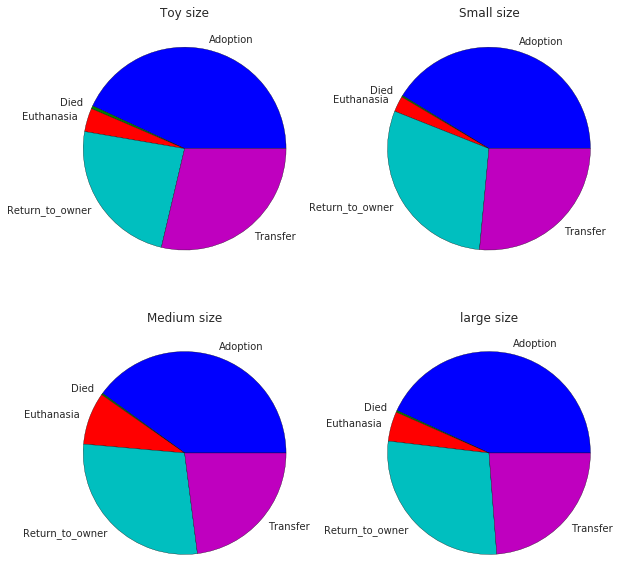

In [888]:


dog_size=DataFrame({'size':dogsize(s1)})
dog_size2=DataFrame({'size':dogsize(s2)})
b=pd.concat([dog_size, dog.OutcomeType],axis=1).groupby(['OutcomeType','size']).size().unstack().reset_index()
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.pie(b[0],labels=b.OutcomeType) 
plt.title('Toy size')
plt.subplot(222)
plt.pie(b[1],labels=b.OutcomeType) 
plt.title('Small size')
plt.subplot(223)
plt.pie(b[2],labels=b.OutcomeType) 
plt.title('Medium size')
plt.subplot(224)
plt.pie(b[3],labels=b.OutcomeType) 
plt.title('large size')


In [562]:
# this outs the list array into a column
g=DataFrame({'type':t1})
#get binary vectors, and break the list element up
dog_type=g['type'].str.join(sep='*').str.get_dummies(sep='*')

g2=DataFrame({'type':t2})#test data
dog_type2=g2['type'].str.join(sep='*').str.get_dummies(sep='*')#test data



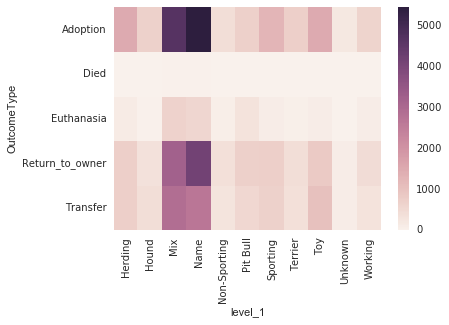

In [563]:
import seaborn as sns
dog_data=pd.concat([dog,dog_type],axis=1) # yay!!! got it to work, this works too with string dataframe g above!

#sum up the counts vs. outcome type!
dogtype_count=DataFrame({'count':dog_data.drop(['age(days)','Sterilization'], axis=1).groupby(['OutcomeType']).sum().stack()}).reset_index()
#dogtypesum=dogtype_count.pivot(index='level_1', columns='OutcomeType')
#p1=dogtypesum.plot(kind='bar',stacked=True, colormap='Set3')
sns.heatmap(dogtype_count.pivot('OutcomeType','level_1','count')) # shows outcome by the number in each breed/type
# to access a row-->dog.iloc[[4]], [] gives summary not array

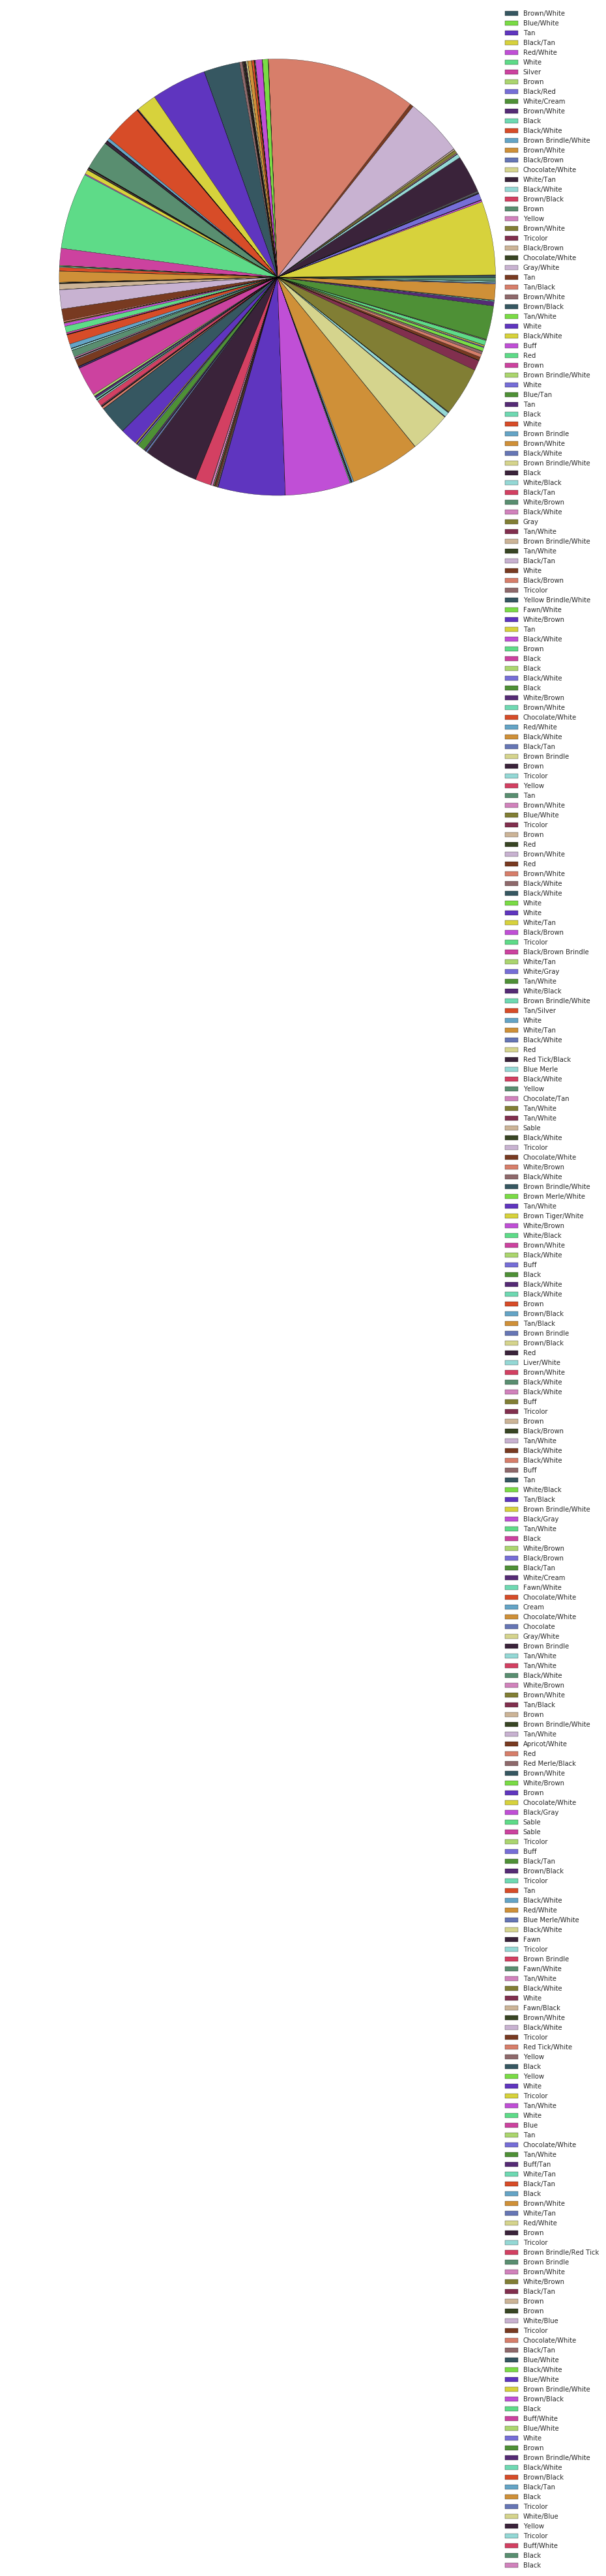

In [564]:
cat_groups=DataFrame(cat.groupby(cat.Breed).size()).reset_index()
cat_groups=cat_groups.rename(columns=({0:'count'}))
#set color schemes
c=["#365761",
"#7adb45",
"#5f35bf",
"#d7d23c",
"#c04fd6",
"#5edb88",
"#cc429f",
"#abd56e",
"#766ed7",
"#4e9036",
"#552b75",
"#6ed9b2",
"#d74c28",
"#64a4c6",
"#cf9038",
"#6676b5",
"#d5d48d",
"#3a233a",
"#94d8d5",
"#d34062",
"#598e70",
"#d182bc",
"#817e34",
"#812f4e",
"#ccb497",
"#384524",
"#c8b2d1",
"#783a21",
"#d77e6a",
"#8e696b"]
dog_color=DataFrame(dog.groupby(dog.Color).size()).reset_index()
d2=dog_color.rename(columns=({0:'count'}))

plt.figure(figsize=(15,15))
plt.pie(d2['count'], colors=c)
plt.legend(dog['Color'], bbox_to_anchor=(1.1,1),loc=0)
#texts.set_size'smaller')
#texts[0].set_fontsize(10)


In [565]:
top5=cat_groups.sort_values('count', ascending=False)
top5=top5[0:5]
top5.sum()[1]/cat_groups.sum()[1]

#the top 5 cat breeds make up 96% of population!
top_cat=np.array(top5.Breed)



In [566]:
def cattyping(items):
    cat_group_val=[]
    cat_count=0
    for i in items:
            cat_group=[]
# for the breed categories with top cat breed   
            if i in top_cat:
                indx = np.where(top_cat == i)[0]
                cat_group.append(top_cat[indx][0])
            
                #for lower case letters
            elif np.any([s.lower() in i.lower() for s in top_cat]):
                find_group2 = [s if s.lower() in i.lower() else 'Others' for s in top_cat]                    
                cat_group.append(find_group2[find_group2 != 'Others'])
           
            else:
                cat_group.append('Others')
            
            cat_group_val.append(cat_group)
        
    return cat_group_val


In [889]:
z1=cattyping(cat.Breed)#training data set
z2=cattyping(cat2.Breed) #test data set

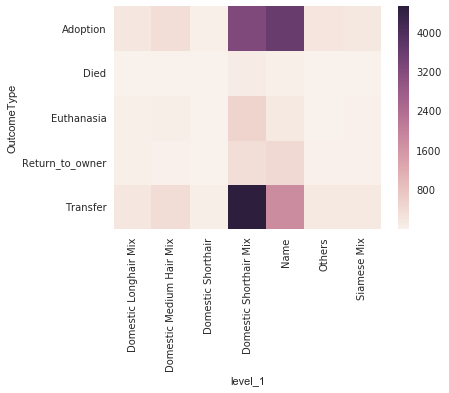

In [568]:

c=DataFrame({'type':z1})
c2=DataFrame({'type':z2})

cat_type=c['type'].str.join(sep='*').str.get_dummies(sep='*') #this allows it to recognize space in name!
cat_data=pd.concat([cat,cat_type],axis=1)
#test set
cat_type2=c2['type'].str.join(sep='*').str.get_dummies(sep='*') #this allows it to recognize space in name!

cattype_count=DataFrame(cat_data.drop(['age(days)','Sterilization'],axis=1).groupby(['OutcomeType']).sum().stack()).reset_index()
sns.heatmap(cattype_count.pivot('OutcomeType','level_1',0))


In [570]:
color_group=np.array(['Black','Brown','White','Tan', 'Blue','Tricolor', 'Orange', 'Tabby'])

#group color reference to be used for dog and cat

In [897]:
def animalcolor (items):
    groups_val=[]
    not_found=[]
    count=0
    for i in items:
   
        groups=[]
# for the breed categories with / 
        if '/' in i: 
            splitn=i.split('/')
            for j in splitn:
                if j in color_group:
                    indx=np.where(color_group==j)[0] #using np.where to find indices of matching elements in ARRAY, not list
                #the [0] turns it into array element, not an entire array
                    groups.append(color_group[indx][0])
                
                # for lower case letter
                else:               
                    groups.append('other_mixedcolor')
        elif ' ' in i: 
            splitn=i.split(' ')
            for j in splitn:
                if j in color_group:
                    indx=np.where(color_group==j)[0] #using np.where to find indices of matching elements in ARRAY, not list
                #the [0] turns it into array element, not an entire array
                    groups.append(color_group[indx][0])
                
                # for lower case letter
                else:               
                    groups.append('other_mixedcolor')
#for just plain color, no '/'      
        else:
                if i in color_group:
                    indx = np.where(color_group == i)[0]
                    groups.append(color_group[indx][0])
                else:
                    groups.append('other_solidcolor')
        groups_val.append(list(set(groups)))
    return groups_val
                

In [898]:
f1=DataFrame({'hue':animalcolor(dog.Color)})
k1=DataFrame({'hue':animalcolor(cat.Color)})
k2=DataFrame({'hue':animalcolor(cat2.Color)})
dog_color=f1['hue'].str.join(sep='*').str.get_dummies(sep='*')
cat_color=k1['hue'].str.join(sep='*').str.get_dummies(sep='*')
cat_color2=k2['hue'].str.join(sep='*').str.get_dummies(sep='*')


In [899]:
dog.Sterilization= dog.Sterilization.replace('Unknown','NA')
cat.Sterilization= cat.Sterilization.replace('Unknown','NA')
#test
dog2.Sterilization= dog2.Sterilization.replace('Unknown','NA')
cat2.Sterilization= cat2.Sterilization.replace('Unknown','NA')

C:\Users\yuy\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [900]:
enc=preprocessing.LabelEncoder()
cat_outcome=enc.fit_transform(cat_data.OutcomeType)
dog_outcome=enc.fit_transform(dog_data.OutcomeType)


In [938]:
dog_Sex=pd.get_dummies(dog.Sex)
cat_Sex=pd.get_dummies(cat.Sex)

from sklearn import preprocessing
#only labelencoder works on categorical columns


cat_steril=pd.get_dummies(cat.Sterilization)
dog_steril=pd.get_dummies(dog.Sterilization)
cat_hours=cat.DateTime.dt.hour
dog_hours=dog.DateTime.dt.hour



dog_days=pd.get_dummies(dog_data.day)
dog_months=pd.get_dummies(dog_data.month)
cat_days=pd.get_dummies(cat_data.day)
cat_months=pd.get_dummies(cat_data.month)
dog_train=pd.concat([dog_data['Name'],  dog_hours,dog_days, dog_months, dog_data['age(days)'], dog_size, dog_Sex, dog_steril, dog_type], axis=1)
dog_train['outcome']=dog_outcome
cat_train=pd.concat([cat_data['Name'], cat_hours, cat_days, cat_months, cat_data['age(days)'], cat_Sex, cat_steril, cat_type, cat_color], axis=1)
cat_train['outcome']=cat_outcome
cat_train.columns


Index(['Name', 'DateTime', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',
       'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Sep', 'age(days)', 'Female', 'Male', 'Intact', 'NA', 'Neutered',
       'Spayed', 'Domestic Longhair Mix', 'Domestic Medium Hair Mix',
       'Domestic Shorthair', 'Domestic Shorthair Mix', 'Others', 'Siamese Mix',
       'Black', 'Blue', 'Brown', 'Orange', 'Tabby', 'Tan', 'Tricolor', 'White',
       'other_mixedcolor', 'other_solidcolor', 'outcome'],
      dtype='object')

In [1183]:
###for test data
dog2_Sex=pd.get_dummies(dog2.Sex)
cat2_Sex=pd.get_dummies(cat2.Sex)
cat_steril2=pd.get_dummies(cat2.Sterilization)
dog_steril2=pd.get_dummies(dog2.Sterilization)
cat_hours2=cat2.DateTime.dt.hour
dog_hours2=dog2.DateTime.dt.hour
dog_days2=pd.get_dummies(dog2.day)
cat_days2=pd.get_dummies(cat2.day)
dog_months2=pd.get_dummies(dog2.month)
cat_months2=pd.get_dummies(cat2.month)

dog_type2=dog_type2.set_index(dog2.index.values)
cat_type2=cat_type2.set_index(cat2.index.values)
dog_size2=dog_size2.set_index(dog2.index.values)
cat_color2=cat_color2.set_index(cat2.index.values)

dog_test=pd.concat([dog2.Name, dog_hours2, dog_days2, dog_months2, dog2['age(days)'], dog_size2, dog2_Sex, dog_steril2, dog_type2],axis=1)
cat_test=pd.concat([cat2.Name, cat_hours2, cat_days2, cat_months2, cat2['age(days)'], cat2_Sex, cat_steril2, cat_type2,cat_color2], axis=1)
dog_test.columns


Index(['Name', 'DateTime', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',
       'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Sep', 'age(days)', 'size', 'Female', 'Male', 'Intact', 'NA',
       'Neutered', 'Spayed', 'Herding', 'Hound', 'Mix', 'Non-Sporting',
       'Pit Bull', 'Sporting', 'Terrier', 'Toy', 'Unknown', 'Working'],
      dtype='object')

In [942]:
#for dogs,  try PCA to find  multicollinearity, drop Unknown and Sporting column
features=dog_train.columns.drop(['outcome','Unknown','Sporting'])
features_d2=dog_test.columns.drop(['Unknown','Sporting'])
training_d, validation_d = train_test_split(dog_train, train_size=.60, random_state=3)


In [ ]:
#q=pd.concat([dog2,cat2])
#q.sort_index() sort by index to return to original data!

clf = XGBClassifier(objective='multi:softprob', n_estimators=300, subsample=0.8, gamma=1.3)
 #tweak max_depth, min_child_weight
clf.fit(training_d[features], training_d['outcome'],
        early_stopping_rounds=6,
        eval_set=[(training_d[features], training_d['outcome']),(validation_d[features], validation_d['outcome'])],
        eval_metric='mlogloss')

In [1158]:
dtrain=xgb.DMatrix(training_d[features], label=training_d['outcome'])
dtest=xgb.DMatrix(validation_d[features], label=validation_d['outcome'])



param={
 'eval_metric': 'mlogloss',
 'max_depth': 4,
 'num_class': 5,
'learning_rate': 0.1,
 'objective': 'multi:softprob',
  'gamma': 1.5,
  'min_child_weight': 3.08,
  'subsample': 0.8,
   'n_estimators': 500,
   }
Watchlist = [(dtrain,'train'),(dtest,'test')]
bst = xgb.train (param, dtrain, 500, Watchlist, early_stopping_rounds = 10 )
#pred = bst.predict (dtest);


Will train until test error hasn't decreased in 10 rounds.
[0]	train-mlogloss:1.531469	test-mlogloss:1.532486
[1]	train-mlogloss:1.466306	test-mlogloss:1.467995
[2]	train-mlogloss:1.410160	test-mlogloss:1.412838
[3]	train-mlogloss:1.361866	test-mlogloss:1.365725
[4]	train-mlogloss:1.319761	test-mlogloss:1.324158
[5]	train-mlogloss:1.282874	test-mlogloss:1.288163
[6]	train-mlogloss:1.249817	test-mlogloss:1.255559
[7]	train-mlogloss:1.220374	test-mlogloss:1.226615
[8]	train-mlogloss:1.194383	test-mlogloss:1.201233
[9]	train-mlogloss:1.170742	test-mlogloss:1.178491
[10]	train-mlogloss:1.149703	test-mlogloss:1.158052
[11]	train-mlogloss:1.130288	test-mlogloss:1.139391
[12]	train-mlogloss:1.112777	test-mlogloss:1.122638
[13]	train-mlogloss:1.096859	test-mlogloss:1.107390
[14]	train-mlogloss:1.081922	test-mlogloss:1.093583
[15]	train-mlogloss:1.068683	test-mlogloss:1.080743
[16]	train-mlogloss:1.056465	test-mlogloss:1.069187
[17]	train-mlogloss:1.045236	test-mlogloss:1.058759
[18]	train-mlog

In [1173]:
predict1=np.array(bst.predict(dtest))
log_loss(validation_d['outcome'], predict1) 
#clf.score(validation_d[features], validation_d['outcome'])#this is the accuracy




0.91282176880348675

In [1190]:
#do XGB on dog test data
w1=xgb.DMatrix(dog_test[features])
p1=np.array(bst.predict(w1))
prediction_dog=DataFrame(p1).set_index(dog2.index.values)

,0,1,2,3,4
0,0.025012,0.004862,0.033398,0.192929,0.743800
1,0.757223,0.001004,0.009013,0.174324,0.058435
3,0.106920,0.007364,0.027180,0.377594,0.480943
4,0.396541,0.001278,0.007868,0.471582,0.122732
5,0.176645,0.001091,0.014379,0.521150,0.286734
8,0.842342,0.000822,0.002947,0.117741,0.036148
9,0.514382,0.001203,0.050864,0.337268,0.096283
10,0.773663,0.001331,0.002942,0.146456,0.075607
11,0.040184,0.002361,0.264508,0.298825,0.394122
12,0.630231,0.001273,0.007321,0.124920,0.236255


#GridSearchCV had some issues working on these datasets
from sklearn.grid_search import GridSearchCV 
param_test1 = {'max_depth': np.arange(3,10,2)}
clf1=XGBClassifier(learning_rate =0.1, n_estimators=246, subsample=0.8, gamma=1.3, objective= 'multi:softmax', seed=27)
gsearch1 = GridSearchCV(clf1,{'max_depth': [2,4,6]},scoring='log_loss')


gsearch1.fit(validation_d[features], validation_d['outcome'])


In [925]:
features_c2=cat_train.columns.drop('outcome')
training_c, validation_c = train_test_split(cat_train, train_size=.60, random_state=3)


In [1191]:
ctrain=xgb.DMatrix(training_c[features_c2], label=training_c['outcome'])
ctest=xgb.DMatrix(validation_c[features_c2], label=validation_c['outcome'])

param={
 'eval_metric': 'mlogloss',
 'max_depth': 5,
 'num_class': 5,
'learning_rate': 0.1,
 'objective': 'multi:softprob',
  'gamma': 1.0,
  'min_child_weight': 3.059,
  'subsample': 0.8,
   'n_estimators': 500,
   }
Watchlist = [(ctrain,'train'),(ctest,'test')]
bst_c = xgb.train (param, ctrain, 500, Watchlist, early_stopping_rounds = 10 )


Will train until test error hasn't decreased in 10 rounds.
[0]	train-mlogloss:1.463782	test-mlogloss:1.467705
[1]	train-mlogloss:1.347349	test-mlogloss:1.354976
[2]	train-mlogloss:1.250832	test-mlogloss:1.260889
[3]	train-mlogloss:1.170238	test-mlogloss:1.182962
[4]	train-mlogloss:1.100435	test-mlogloss:1.115657
[5]	train-mlogloss:1.040508	test-mlogloss:1.057877
[6]	train-mlogloss:0.988253	test-mlogloss:1.007607
[7]	train-mlogloss:0.941505	test-mlogloss:0.962667
[8]	train-mlogloss:0.900337	test-mlogloss:0.923282
[9]	train-mlogloss:0.863429	test-mlogloss:0.887751
[10]	train-mlogloss:0.831273	test-mlogloss:0.857472
[11]	train-mlogloss:0.802017	test-mlogloss:0.829492
[12]	train-mlogloss:0.775922	test-mlogloss:0.804840
[13]	train-mlogloss:0.752136	test-mlogloss:0.782652
[14]	train-mlogloss:0.730500	test-mlogloss:0.762103
[15]	train-mlogloss:0.710867	test-mlogloss:0.743947
[16]	train-mlogloss:0.693007	test-mlogloss:0.727503
[17]	train-mlogloss:0.676979	test-mlogloss:0.712807
[18]	train-mlog

In [1192]:
#do XGB on cat test data
ctest=xgb.DMatrix(cat_test)
predict2=np.array(bst_c.predict(ctest))
prediction_cat=DataFrame(predict2).set_index(cat2.index.values)




,0,1,2,3,4
2,0.309791,0.003495,0.010551,0.230705,0.445458
6,0.122069,0.295943,0.433711,0.067160,0.081118
7,0.798812,0.007021,0.007082,0.013636,0.173449
18,0.162866,0.005683,0.030370,0.215269,0.585812
19,0.005550,0.004422,0.176236,0.006705,0.807088
20,0.451870,0.003008,0.017455,0.399250,0.128417
21,0.000754,0.003300,0.065348,0.002500,0.928098
23,0.001279,0.005186,0.009293,0.001037,0.983204
25,0.104074,0.010364,0.134099,0.066793,0.684670
26,0.969403,0.000525,0.001148,0.002411,0.026513


In [1218]:
stuff=pd.concat([prediction_dog,prediction_cat]).sort_index()
stuff.columns=enc.classes_
stuff['ID']=Series(np.arange(1,11457))
#rearrange the column orders
final_prediction=stuff[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]


In [1219]:
final_prediction.to_csv('testPrediction(1).csv', index=False)

In [1220]:
pd.read_csv('testPrediction(1).csv')

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.025012,0.004862,0.033398,0.192929,0.743800
1,2,0.757223,0.001004,0.009013,0.174324,0.058435
2,3,0.309791,0.003495,0.010551,0.230705,0.445458
3,4,0.106920,0.007364,0.027180,0.377594,0.480943
4,5,0.396541,0.001278,0.007868,0.471582,0.122732
5,6,0.176645,0.001091,0.014379,0.521150,0.286734
6,7,0.122069,0.295943,0.433711,0.067160,0.081118
7,8,0.798812,0.007021,0.007082,0.013636,0.173449
8,9,0.842342,0.000822,0.002947,0.117741,0.036148
9,10,0.514382,0.001203,0.050864,0.337268,0.096283


In [2047]:
#multicollinearity

corr=np.corrcoef(training_d[features],rowvar=0)
corr
w,v=np.linalg.eig(corr)
#change labelencoder for outcome as ordinal
#died=0,euthan=1, transfer=2, return to owner=3, adoption=4